In [149]:
from tqdm import tqdm
import librosa as lb
import numpy as np
import pandas as pd

In [150]:
df = pd.read_csv('UrbanSound8K.csv')

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [151]:

model_checkpoint_filepath = './models/mfcc_ann.h5'

training_history_filepath = "./models/mfcc_ann_train_history.pkl"

extracted_data_filepath = "./feature_extraction_data/mfcc_USD_Folds.pkl"

re_train = True #Loads Data, but Retrains Model and gets new History
 


In [152]:
import os
import pickle as pkl
from keras.utils import to_categorical

def mfcc_feature_extractor(path):
    data, simple_rate = lb.load(path, res_type='kaiser_fast')
    data = lb.feature.mfcc(data, n_mfcc=128)
    data = np.mean(data,axis=1)
    return data


#if data has already been extracted and saved
if os.path.exists(extracted_data_filepath):
    
    #loading from pickle
    with open(extracted_data_filepath, 'rb') as f:
        (x, y) = pkl.load(f)
        
    print("* * * Loading Extracted Feature Data * * *")
    print(x.shape, y.shape)

    
#if data has not, feature extract
else:
    
    print("* * * Extracting Feature Data * * *")
    
    x, y = [], []
    for i,rows in tqdm(df.iterrows()):
        path = '../data/UrbanSoundDatabaseFolds/' + 'fold' + str(rows['fold']) + '/' + str(rows['slice_file_name'])
        x.append(mfcc_feature_extractor(path))
        y.append(rows['classID'])
        
    x = np.array(x)
    y = np.array(y)
    y = to_categorical(y)
    
    #saving to pickle
    with open(extracted_data_filepath, 'wb') as file:
        pkl.dump((x, y), file)
        
    x.shape, y.shape

3it [00:00, 24.46it/s]

* * * Extracting Feature Data * * *


3554it [03:06, 19.02it/s]c:\Users\Max Xiao\AppData\Local\Programs\Python\Python38\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8323it [07:09, 25.02it/s]c:\Users\Max Xiao\AppData\Local\Programs\Python\Python38\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
8328it [07:09, 29.09it/s]c:\Users\Max Xiao\AppData\Local\Programs\Python\Python38\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [07:28, 19.46it/s]


In [153]:
from sklearn.model_selection import train_test_split

xtrainval, X_test, ytrainval, y_test = train_test_split(x,y,test_size=0.1,stratify=y,random_state=387)
X_train, X_val, y_train, y_val = train_test_split(xtrainval,ytrainval,test_size=0.2,stratify=ytrainval,random_state=387)
print('\nNumber of samples for Train set :',X_train.shape[0])
print('Number of samples for Validation set :',X_val.shape[0])
print('Number of samples for Test set :', X_test.shape[0])


Number of samples for Train set : 6286
Number of samples for Validation set : 1572
Number of samples for Test set : 874


In [154]:

from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint


model = Sequential()
model.add(Dense(1000, activation='relu', input_shape=(128,)))
model.add(Dense(750, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()


checkpoint = ModelCheckpoint(filepath=model_checkpoint_filepath, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             monitor='val_accuracy', 
                             mode='max', 
                             verbose=1)


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 1000)              129000    
_________________________________________________________________
dense_99 (Dense)             (None, 750)               750750    
_________________________________________________________________
dense_100 (Dense)            (None, 500)               375500    
_________________________________________________________________
dense_101 (Dense)            (None, 250)               125250    
_________________________________________________________________
dense_102 (Dense)            (None, 100)               25100     
_________________________________________________________________
dense_103 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_104 (Dense)            (None, 10)              

In [155]:
import os
from keras.models import load_model


if os.path.exists(model_checkpoint_filepath) and re_train == False:
    model = load_model(model_checkpoint_filepath)
    with open(training_history_filepath, 'rb') as f:
        training = pkl.load(f)
    
    print("* * * Loading Model and Training History * * *")
    
    
else:
    
    print("* * * Training Model * * *")
    
    training = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100, batch_size=64, callbacks=checkpoint)
    with open(training_history_filepath, 'wb') as f:
        pkl.dump(training.history, f)
        
    

* * * Training Model * * *
Epoch 1/100
99/99 [==============================] - 1s 7ms/step - loss: 4.2511 - accuracy: 0.2337 - val_loss: 1.3982 - val_accuracy: 0.5248

Epoch 00001: val_accuracy improved from -inf to 0.52481, saving model to ./models\mfcc_ann.h5
Epoch 2/100
99/99 [==============================] - 1s 6ms/step - loss: 1.2459 - accuracy: 0.5799 - val_loss: 1.0487 - val_accuracy: 0.6501

Epoch 00002: val_accuracy improved from 0.52481 to 0.65013, saving model to ./models\mfcc_ann.h5
Epoch 3/100
99/99 [==============================] - 1s 5ms/step - loss: 0.9246 - accuracy: 0.7099 - val_loss: 0.8086 - val_accuracy: 0.7411

Epoch 00003: val_accuracy improved from 0.65013 to 0.74109, saving model to ./models\mfcc_ann.h5
Epoch 4/100
99/99 [==============================] - 1s 5ms/step - loss: 0.6574 - accuracy: 0.7881 - val_loss: 0.6990 - val_accuracy: 0.7665

Epoch 00004: val_accuracy improved from 0.74109 to 0.76654, saving model to ./models\mfcc_ann.h5
Epoch 5/100
99/99 [=

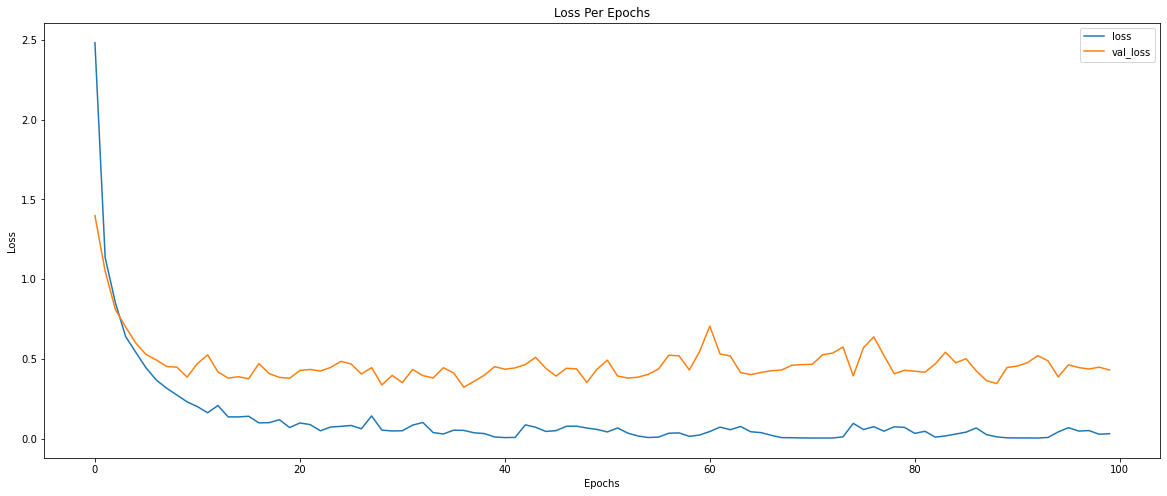

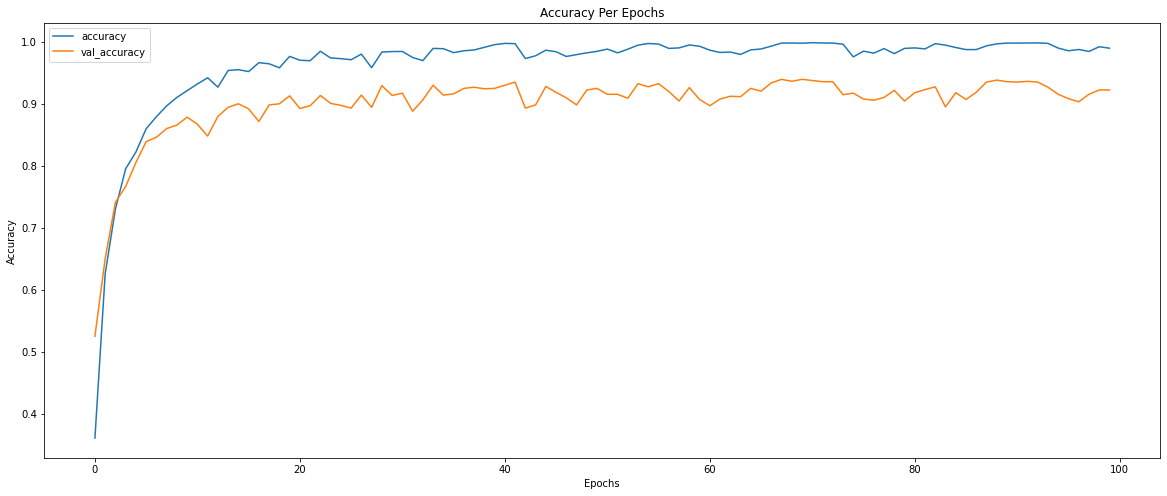

In [156]:
import matplotlib.pyplot as plt

#idk y but this makes it work, if model is being loaded in fully
if os.path.exists(model_checkpoint_filepath) and re_train == False:
    train_hist = pd.DataFrame(training)
else:
    train_hist = pd.DataFrame(training.history)
    

plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['loss','val_loss'])
plt.title('Loss Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

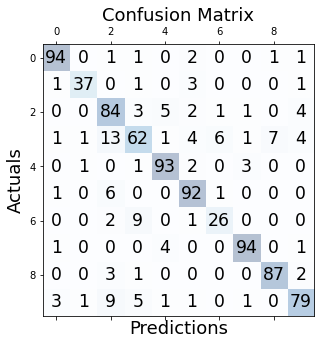

In [157]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

#changing model predictions to one hot encodings
#y_pred = to_categorical(model.predict_classes(X_test))
#y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

#confusion matrixd
conf_matrix = confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes)

#plotting confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [161]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test_classes, y_pred_classes, average=None) 
print("F1 Score:", f1)

F1 Score: [0.93532338 0.89156627 0.7706422  0.67759563 0.91176471 0.88888889
 0.72222222 0.94       0.92553191 0.82291667]


In [163]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)

# Calculate the area under the curve
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ValueError: multilabel-indicator format is not supported